In [ ]:
# default_exp inference.inference

# Inference

> Provides faster inference scripts

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from fastai2.vision.all import *
from fastai2.tabular.all import *

In [ ]:
#export
def _fully_decode(dl, inps, outs, dec_out, is_multi):
    "Attempt to fully decode the `inp"
    if is_multi:
        for i in range(dl.n_inp):
            inps[i] = torch.cat(inps[i], dim=0)
    else: 
        inps = tensor(*inps[0])
    b = (*tuplify(inps), *tuplify(dec_out))
    try:
        outs.insert(len(outs), dl.decode_batch(b))
    except:
        outs.insert(len(outs), dl.decode(b))
    return outs

In [ ]:
#export
def _decode_loss(vocab, dec_out, outs):
    i2c, dec2c = {}, []
    try:
        for i, vocab in enumerate(list(vocab)):
                i2c[i] = vocab
        for i, item in enumerate(dec_out):
            dec2c.append(i2c[int(item)])
        dec_out = dec2c
        outs.insert(0, dec_out)
    except:
        outs.insert(0, dec_out)
    return outs

In [ ]:
#export
@patch
def get_preds(x:Learner, ds_idx=1, dl=None, raw_outs=False, decoded_loss=True, fully_decoded=False,
             **kwargs):
    "Get predictions with possible decoding"
    inps, outs, dec_out, raw = [], [], [], []
    if dl is None: dl = x.dls[ds_idx].new(shuffle=False, drop_last=False)
    is_multi=False
    if x.dls.n_inp > 1: 
        is_multi=True
        [inps.append([]) for _ in range(x.dls.n_inp)]
    x.model.eval()
    for batch in dl:
        with torch.no_grad():
            if fully_decoded:
                if is_multi:
                    for i in range(x.dls.n_inp):
                        inps[i].append(batch[i].cpu())
                else:
                    inps.append(batch[0].cpu())
            if decoded_loss or fully_decoded:
                out = x.model(*batch[:x.dls.n_inp])
                raw.append(out)
                dec_out.append(x.loss_func.decodes(out))
            else:
                raw.append(x.model(*batch[:x.dls.n_inp]))
    raw = torch.cat(raw, dim=0).cpu().numpy()
    if fully_decoded or decoded_loss:
        dec_out = torch.cat(dec_out, dim=0)
    if not raw_outs:
        try: outs.insert(0, x.loss_func.activation(tensor(raw)).numpy())
        except: outs.insert(0, dec_out)
    else:
        outs.insert(0, raw)
    if fully_decoded: outs = _fully_decode(x.dls, inps, outs, dec_out, is_multi)
    if decoded_loss: outs = _decode_loss(x.dls.vocab, dec_out, outs)
    return outs

In [ ]:
show_doc(Learner.get_preds)

<h4 id="Learner.get_preds" class="doc_header"><code>Learner.get_preds</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>Learner.get_preds</code>(**`x`**:`Learner`, **`ds_idx`**=*`1`*, **`dl`**=*`None`*, **`raw_outs`**=*`False`*, **`decoded_loss`**=*`True`*, **`fully_decoded`**=*`False`*, **\*\*`kwargs`**)

Get predictions with possible decoding

You should see a ~33% speed up from these changes. To use, just run `get_preds`. Parameters:
* `ds_idx`: Index of `DataLoader` to use, default is `1`
* `dl`: Optional custom `DataLoader` to pass in
* `raw_outs`: If `True`, will not send probabilities through `loss_func`'s `activation`. Disabled by default
* `decoded_loss`: Whether or not to return your probabilities through the `decodes` in the `loss_func`. Enabled by default
* `fully_decoded`: Returns a fully decoded input and output. Disabled by default

If everything is enabled, it will return in the following order:

decoded classes, Raw predictions, fully decoded array of our inputs and outputs

In [ ]:
#export
@patch
def predict(x:Learner, item, with_input=False, rm_type_tfms=None):
        dl = x.dls.test_dl([item], rm_type_tfms=rm_type_tfms, num_workers=0)
        res = x.get_preds(dl=dl, fully_decoded=True)
        if not with_input: res = res[:-1]
        return res

In [ ]:
#export
@patch
def predict(x:TabularLearner, row, with_input=False, rm_type_tfms=None):
        tst_to = x.dls.valid_ds.new(pd.DataFrame(row).T)
        tst_to.process()
        tst_to.conts = tst_to.conts.astype(np.float32)
        dl = x.dls.valid.new(tst_to)
        res = x.get_preds(dl=dl, fully_decoded=True)
        if not with_input: res = res[:-1]
        return res

## Examples

Below is examples with `Vision`, `Tabular`, and `Text`:

### Vision

We'll use the `PETs` dataset:

In [ ]:
path = untar_data(URLs.PETS)
fnames = get_image_files(path/'images')
pat = r'(.+)_\d+.jpg$'
batch_tfms = [*aug_transforms(size=224, max_warp=0), Normalize.from_stats(*imagenet_stats)]
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.))
bs=64

In [ ]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, batch_tfms=batch_tfms, 
                                   item_tfms=item_tfms, bs=bs)

/home/ml1/anaconda3/envs/fastai2/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)

In [ ]:
name, probs, im  = learn.predict(fnames[0], with_input=True)

In [ ]:
name, probs

(['american_bulldog'],
 array([[5.4036850e-08, 1.2508150e-05, 5.7367719e-04, 1.6557322e-05,
         5.8675050e-07, 9.4942152e-06, 1.3128915e-04, 2.2669528e-04,
         1.5123429e-03, 3.5535620e-04, 6.7200522e-06, 1.4108670e-03,
         6.5473181e-01, 2.1965586e-06, 1.0224058e-04, 2.6679521e-05,
         2.9389782e-06, 5.6439594e-06, 2.0075787e-03, 5.5477295e-07,
         4.7834524e-06, 1.1920198e-01, 9.0194138e-05, 4.4012382e-03,
         2.2389761e-06, 1.7345719e-05, 1.5751538e-01, 1.7798202e-02,
         9.1721234e-04, 5.8656198e-05, 7.4576652e-05, 2.7504394e-02,
         2.7728875e-05, 8.8391062e-06, 1.0579181e-06, 4.8880913e-05,
         1.1191423e-02]], dtype=float32))

For images we can also plot the original image with the label, see the below format:

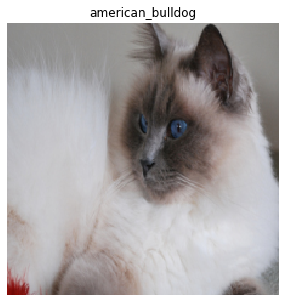

In [ ]:
im[0][0].show(title=im[0][1])

In [ ]:
preds = learn.get_preds(raw_outs=False, decoded_loss=True)

The first index will contain our names

In [ ]:
preds[0][:5]

['miniature_pinscher',
 'american_bulldog',
 'yorkshire_terrier',
 'american_bulldog',
 'american_bulldog']

Second the probabilities

In [ ]:
preds[1][0]

array([3.2122482e-09, 9.2809310e-10, 2.6805562e-06, 2.4596255e-07,
       9.2499477e-07, 2.9771888e-07, 3.4656869e-06, 3.0754602e-06,
       2.4156500e-07, 6.6360005e-04, 2.4881061e-07, 1.2394010e-05,
       1.7754669e-01, 1.2502475e-06, 1.1650380e-09, 1.0498035e-07,
       1.3206963e-07, 2.0722771e-07, 2.4511126e-08, 4.5438459e-11,
       6.8098856e-08, 8.6427764e-07, 1.5830333e-09, 9.8504387e-08,
       2.6947585e-08, 1.0634259e-07, 8.1115156e-01, 1.4425168e-03,
       7.1394948e-05, 1.5626139e-08, 8.2752158e-05, 2.7497392e-05,
       3.5230499e-03, 1.6435953e-11, 1.8806931e-07, 2.3814651e-05,
       5.4404568e-03], dtype=float32)

### Tabular

We'll use the `ADULT_SAMPLE` dataset:

In [ ]:
from fastai2.tabular.all import *

In [ ]:
path = untar_data(URLs.ADULT_SAMPLE)

In [ ]:
df = pd.read_csv(path/'adult.csv')
splits = RandomSplitter()(range_of(df))
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']
procs = [Categorify, FillMissing, Normalize]
y_names = 'salary'

In [ ]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names,
                   y_names=y_names, splits=splits)

In [ ]:
dls = to.dataloaders()

In [ ]:
learn = tabular_learner(dls, layers=[200,100])

In [ ]:
name, probs, row = learn.predict(df.iloc[0], with_input=True)

In [ ]:
%%timeit
name, probs = learn.predict(df.iloc[0], with_input=False)

25.1 ms ± 40 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
name, probs

(['>=50k'], array([[0.49027333, 0.5097267 ]], dtype=float32))

For tabular, our input is a `TabularPandas` row, so we can call `row.show()` to show the `DataFrame`:

In [ ]:
row.show()

,workclass,education,marital-status,occupation,relationship,race,education-num_na,age,fnlwgt,education-num,salary
0,Private,Assoc-acdm,Married-civ-spouse,#na#,Wife,White,False,49.0,101319.998642,12.0,>=50k


In [ ]:
preds = learn.get_preds(raw_outs=False, decoded_loss=True)

In [ ]:
preds[0][:3]

['>=50k', '>=50k', '>=50k']

In [ ]:
preds[1][:3]

array([[0.48257712, 0.51742285],
       [0.48117924, 0.5188207 ],
       [0.4867417 , 0.51325834]], dtype=float32)